<a href="https://colab.research.google.com/github/yifeili6/DL_BP_tutorial/blob/main/tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# training

## model structure

In [ ]:
import torch
import torch.nn as nn
class TwoLayerNet(nn.Module):
    def __init__(self, input_dim, hidden_size, output_size):
        """
        :param input_dim: input feature dimension
        :param hidden_size: hidden dimension
        :param num_classes: total number of classes
        """
        super().__init__()
        self.lin0 = torch.nn.Linear(input_dim, hidden_size)
        self.lin1 = torch.nn.Linear(hidden_size, output_size)
        self.act = torch.nn.Sigmoid()



        self.outputs = dict()
        def activation_hook_with_name(name):
          def activation_hook(inst, inp, out):
              """Run activation hook.
              Parameters
              ----------
              inst : torch.nn.Module
                  The layer we want to attach the hook to.
              inp : tuple of torch.Tensor
                  The input to the `forward` method.
              out : torch.Tensor
                  The output of the `forward` method.
              """
              self.outputs[name] = out
          return activation_hook

        self.downstream_grad = dict()
        self.upstream_grad = dict()
        def backward_hook_with_name(name):
          def backward_hook(inst, downstream_grad, upstream_grad):
              """Run activation hook.
              Parameters
              ----------
              inst : torch.nn.Module
                  The layer we want to attach the hook to.
              grad_input :
              grad_output :
              """
              self.downstream_grad[name] = downstream_grad
              self.upstream_grad[name] = upstream_grad
          return backward_hook

        for name, layer in self.named_children(): #  named_module()
             layer.__name__ = name
             layer.register_forward_hook(activation_hook_with_name(name))
             layer.register_full_backward_hook(backward_hook_with_name(name))



    def forward(self, x):
        out = None
        x   = self.lin0(x)
        x   = self.act(x)
        out = self.lin1(x)
        return out

## training, validation functions

In [ ]:
import time
import copy
import numpy as np
import torch
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
! pip install pytorch_lightning
import pytorch_lightning as pl

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(epoch, data_loader, model, optimizer, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()

    for batch_idx, (data, target) in enumerate(data_loader):
        start = time.time()
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        optimizer.zero_grad()
        out = model(data)

        loss = criterion(out, target) #loss = (out - target).pow(2).mean()
        loss.backward()
        optimizer.step()

        losses.update(loss, out.shape[0])
        iter_time.update(time.time() - start)

    #print(f"loss value = {loss}")
    return losses.avg


def validate(epoch, val_loader, model, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()

    # evaluation loop
    for batch_idx, (data, target) in enumerate(val_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        with torch.no_grad():
            out = model(data)
            loss = criterion(out, target)

        losses.update(loss, out.shape[0])
        iter_time.update(time.time() - start)


    return losses.avg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 13.9 MB/s eta 0:00:00


## loading data

In [ ]:
batch_size    = 128
pl.seed_everything(42)
# data and data loader
B = 128*4
C = 3072
train_dataset = torch.randn(B, C), torch.randint(0, 10, (B,1)).float()
test_dataset  = torch.randn(B, C), torch.randint(0, 10, (B,1)).float()
train_dataset = torch.utils.data.TensorDataset(*train_dataset)
test_dataset  = torch.utils.data.TensorDataset(*test_dataset)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader   = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [ ]:
train_dataset

## plotting utils

In [ ]:
def plot_activation_gradient(model, epoch):
   #fig = plt.subplots(2, len(model.outputs), figsize=(15, 15))
    for index, (key, value) in enumerate(model.outputs.items()):
        hy, hx = torch.histogram(value, density=True)
        ax = plt.subplot(2, len(model.outputs), index+1)
        ax.plot(hx[:-1].detach(),  hy.detach())
        ax.set_title(f"{key} output")
        ax.set_xlabel('output value')
        ax.set_ylabel('density')
    for index, (key, value) in enumerate(model.upstream_grad.items()):
        hy, hx = torch.histogram(value[0], density=True)
        ax = plt.subplot(2, len(model.upstream_grad), index+1+len(model.upstream_grad))
        ax.plot(hx[:-1].detach(),  hy.detach())
        ax.set_title(f"{key} gradient")
        ax.set_xlabel('gradient value')
        ax.set_ylabel('density')
    legends.append(f'epochs {epoch}')
    plt.legend(legends, bbox_to_anchor = [1 , 2])
    plt.tight_layout()

def plot_loss(losses):
  plt.plot(losses)
  plt.xlabel('epoch')
  plt.ylabel('loss')

## actual training

20.577177047729492
17.885833740234375
12.616623878479004
9.772845268249512
4.421680927276611
4.5077714920043945
2.8436203002929688
1.954979658126831
1.4136685132980347
1.0279730558395386


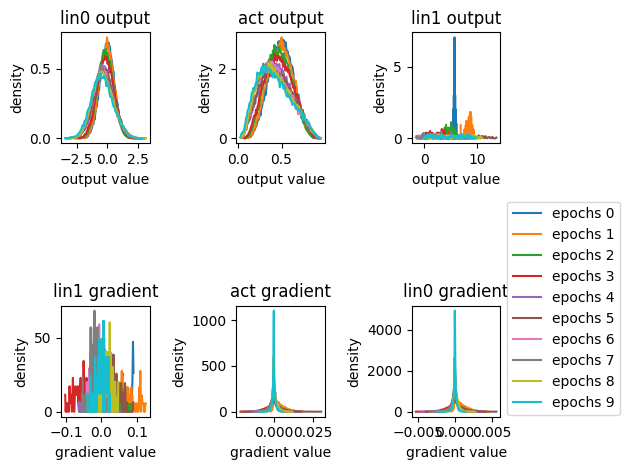

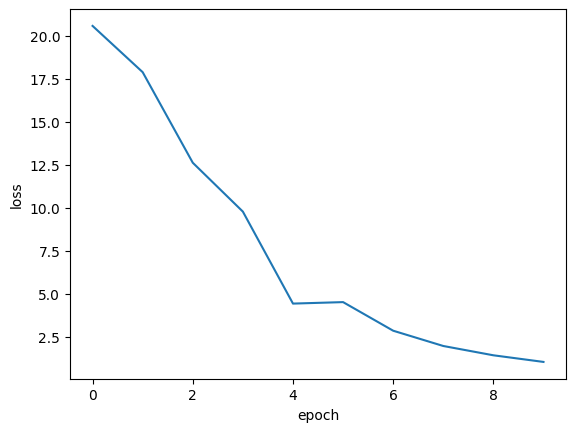

In [ ]:
criterion     = nn.MSELoss()
learning_rate = 0.01
reg      = 0.0005
momentum = 0.9
epochs   = 10
save_best= True
best_model = None

best = 100
train_losses = []
legends = []

# initialize model and optimizer
model = TwoLayerNet(3072, 256, 1)
if torch.cuda.is_available():
    model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum,
                            weight_decay=reg)


# training
model.train()
for epoch in range(epochs):
    # train loop
    train_loss = train(epoch, train_loader, model, optimizer, criterion)
    train_losses.append(train_loss.item())
    print(train_loss.item())
    # visualize training output, upstream gradient
    if epoch % 1 == 0 :
        plot_activation_gradient(model, epoch)
        #plot_upstream_grad(model, epoch)

    # validation loop
    val_loss = validate(epoch, test_loader, model, criterion)

    if val_loss < best:
        best = val_loss
        best_model = copy.deepcopy(model)
        torch.save(dict(model= best_model.state_dict(), optimizer = optimizer.state_dict()), 'best_model.pth')


#plt.figsize(12,12)
plt.show()
# visualize loss
plot_loss(train_losses)
plt.show()

# load saved model

lin0.weight 	 torch.Size([256, 3072])
lin0.bias 	 torch.Size([256])
lin1.weight 	 torch.Size([1, 256])
lin1.bias 	 torch.Size([1])
6.2972941398620605
3.5952038764953613
2.370260715484619
2.5865094661712646
2.18226957321167
1.3890995979309082
1.0687456130981445
0.9781205058097839
0.5703834891319275
0.561184287071228


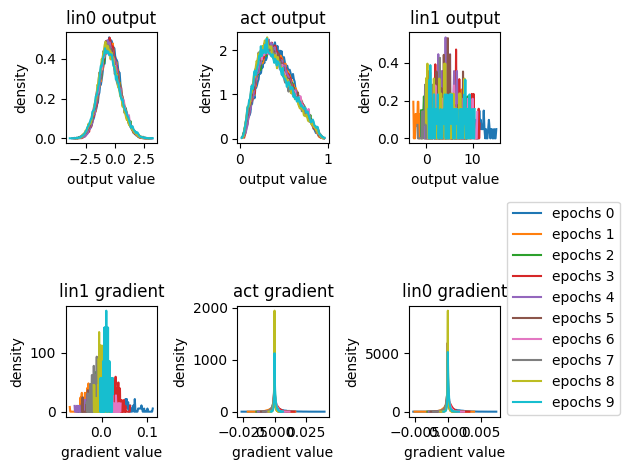

In [ ]:

# load model
model = TwoLayerNet(3072, 256, 1)
model.load_state_dict(torch.load('best_model.pth')['model'])

for param_tensor in model.state_dict(): # check what is saved
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


# load optimizer (optional)
optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum,
                            weight_decay=reg)
optimizer.load_state_dict(torch.load('best_model.pth')['optimizer'])


# evaluate saved model
model.eval()
losses = train(1, train_loader, model, optimizer, criterion)


model.train()
# continue training
for epoch in range(epochs):
    # train loop
    train_loss = train(epoch, train_loader, model, optimizer, criterion)
    train_losses.append(train_loss.item())
    print(train_loss.item())
    # visualize training output, upstream gradient
    if epoch % 1 == 0 :
        plot_activation_gradient(model, epoch)
        #plot_upstream_grad(model, epoch)

    # validation loop
    val_loss = validate(epoch, test_loader, model, criterion)

    if val_loss < best:
        best = val_loss
        best_model = copy.deepcopy(model)

        torch.save(best_model.state_dict(), 'best_model.pth')

# supplements: Data Loader

In [ ]:
from sklearn.datasets import make_classification
import pandas as pd
train, target = make_classification(n_samples = 5000, n_features = 10, n_informative= 8 , n_classes = 2)
train[[0,2,3],:]

array([[-0.95469755, -5.02489968, -1.32559819,  0.65119913, -0.90495669,
         5.1102704 ,  5.54020378, -1.49913187, -2.387684  , -4.10706324],
       [ 0.25238632,  0.25212643, -0.81538308, -0.8517135 , -2.07299515,
        -3.7233294 , -0.64690166, -0.79796091, -1.34417518, -2.21864241],
       [ 0.65838494,  1.13014048,  0.85690564, -0.47340782,  0.53501807,
        -0.98363071,  0.87734467, -0.58647137, -0.40354877, -1.03116701]])

In [ ]:
class custdata(torch.utils.data.Dataset):
  def __init__(self, train, target):
    self.train = train
    self.target = target

  def __len__(self):
    return self.train.shape[0]

  def __getitem__(self, idx):
    # return each tensor wrt the index
    train_sel_idx  = torch.from_numpy(self.train[idx]).float()
    target_sel_idx = torch.from_numpy(np.array(self.target[idx])).float() #.view(-1,1)
    return train_sel_idx, target_sel_idx

#custdata(train,target).__dir__
custdata(train,target).__getitem__([0,2,3])

(tensor([[-0.9547, -5.0249, -1.3256,  0.6512, -0.9050,  5.1103,  5.5402, -1.4991,
          -2.3877, -4.1071],
         [ 0.2524,  0.2521, -0.8154, -0.8517, -2.0730, -3.7233, -0.6469, -0.7980,
          -1.3442, -2.2186],
         [ 0.6584,  1.1301,  0.8569, -0.4734,  0.5350, -0.9836,  0.8773, -0.5865,
          -0.4035, -1.0312]]),
 tensor([1., 1., 1.]))

In [ ]:
cd = custdata(train,target)
dl = torch.utils.data.DataLoader(cd,
                                 batch_size = 16,
                                 shuffle = True,
                                 num_workers = 1)

In [ ]:
for train, target in dl:
  print(f"train shape = {train.shape}")
  print(f"target shape = {target.shape}")
  break

train shape = torch.Size([16, 10])
target shape = torch.Size([16])
